# QAT on Cifar10

In this notebook, we will create a custom dataset for cifar10. We will use Brevitas for quantization-aware for training.

Check files under the current working directory.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchinfo
# Import necessary libraries
import os
from PIL import Image

In [2]:
# Define the transformation to apply to each image in the dataset
# - transforms.ToTensor(): Converts the images to PyTorch tensors
# - transforms.Normalize(): Normalizes the images with mean and standard deviation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define the batch size for loading data
batch_size = 4

# Load the CIFAR-10 training dataset
# - root: Directory to store the dataset
# - train: True means loading the training set
# - download: True means the dataset will be downloaded if not available locally
# - transform: Applies the defined transformations to the dataset
trainset = torchvision.datasets.CIFAR10(root='./dataset', train=True,
                                        download=True, transform=transform)

# Create a data loader for the training set
# - batch_size: Number of samples per batch
# - shuffle: True means the data will be shuffled (randomly mixed)
# - num_workers: Number of subprocesses to use for data loading
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Load the CIFAR-10 test dataset
# - train: False means loading the test set
# - download: True means the dataset will be downloaded if not available locally
# - transform: Applies the defined transformations to the dataset
testset = torchvision.datasets.CIFAR10(root='./dataset', train=False,
                                       download=True, transform=transform)

# Create a data loader for the test set
# - batch_size: Number of samples per batch
# - shuffle: False means the data will not be shuffled
# - num_workers: Number of subprocesses to use for data loading
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Define the class names in the CIFAR-10 dataset
# These are the labels for the 10 different classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


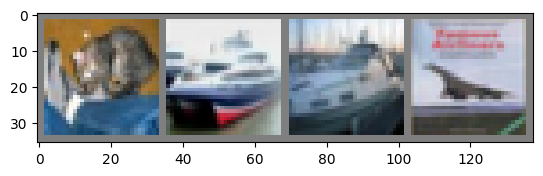

cat   ship  ship  plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Use GPU

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


Define a Convolutional Neural Network
========================================

Copy the neural network from the Neural Networks section before and
modify it to take 3-channel images (instead of 1-channel images as it
was defined).


In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Define the neural network by inheriting from nn.Module
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the first convolutional layer
        # - in_channels: Number of input channels (3 for RGB images)
        # - out_channels: Number of output channels (6 filters)
        # - kernel_size: Size of the convolutional kernel (5x5)
        self.conv1 = nn.Conv2d(3, 6, 5)

        # Define a max-pooling layer
        # - kernel_size: Size of the pooling window (2x2)
        # - stride: Step size for the window (2)
        self.pool = nn.MaxPool2d(2, 2)

        # Define the second convolutional layer
        # - in_channels: Number of input channels (6 from previous conv layer)
        # - out_channels: Number of output channels (16 filters)
        # - kernel_size: Size of the convolutional kernel (5x5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Define the first fully connected layer
        # - in_features: Number of input features (16 * 5 * 5 from previous layers)
        # - out_features: Number of output features (120)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)

        # Define the second fully connected layer
        # - in_features: Number of input features (120)
        # - out_features: Number of output features (84)
        self.fc2 = nn.Linear(120, 84)

        # Define the third fully connected layer
        # - in_features: Number of input features (84)
        # - out_features: Number of output features (10, for 10 classes)
        # self.fc3 = nn.Linear(84, 10)
        self.fc3 = nn.Linear(84, 10)

    # Define the forward pass
    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation and max-pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Apply the second convolutional layer followed by ReLU activation and max-pooling
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the tensor, keeping the batch dimension
        x = torch.flatten(x, 1)

        # Apply the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))

        # Apply the second fully connected layer followed by ReLU activation
        x = F.relu(self.fc2(x))

        # Apply the third fully connected layer to produce the final output
        x = self.fc3(x)

        return x

# Create an instance of the neural network and move it to the specified device (CPU or GPU)
net = Net().to(device)

print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
torchinfo.summary(net, (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Linear: 1-5                            [1, 120]                  48,120
├─Linear: 1-6                            [1, 84]                   10,164
├─Linear: 1-7                            [1, 10]                   850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.31

Train the network
====================

This is when things start to get interesting. We simply have to loop
over our data iterator, and feed the inputs to the network and optimize.


In [7]:
# Define function to calculate accuracy
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [8]:
def calculate_loss(loader, model, criterion):
    total_loss = 0.0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(loader)

In [9]:
def train_model(model, train_loader, test_loader, num_epochs=10):
    # Define the loss function and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []

    print("Start Training:")
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0  # Initialize the running loss for each epoch
        correct = 0
        total = 0

        model.train()  # Set the network to training mode

        for data in train_loader:
            # Get the inputs and labels from the data loader
            inputs, labels = data

            # Move the inputs and labels to the specified device (CPU or GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients to avoid accumulation from previous iterations
            optimizer.zero_grad()

            # Perform the forward pass: compute the network's outputs
            outputs = model(inputs)

            # Compute the loss using the criterion
            loss = criterion(outputs, labels)

            # Perform the backward pass: compute the gradients
            loss.backward()

            # Update the network parameters using the optimizer
            optimizer.step()

            # Accumulate the loss for the current mini-batch
            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

        # Evaluate on the test set
        model.eval()  # Set the network to evaluation mode
        test_accuracy = calculate_accuracy(test_loader, model)
        test_loss = calculate_loss(test_loader, model, criterion)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    print('Finished Training')
    return train_accuracies, train_losses, test_accuracies, test_losses

In [10]:
# Call the training function
train_accs, train_losses, test_accs, test_losses = train_model(net, trainloader, testloader, num_epochs=10)

Start Training:
Epoch [1/10], Loss: 1.7297, Training Accuracy: 36.49%
Epoch [1/10], Test Loss: 1.4172, Test Accuracy: 49.10%
Epoch [2/10], Loss: 1.3410, Training Accuracy: 52.05%
Epoch [2/10], Test Loss: 1.2636, Test Accuracy: 54.59%
Epoch [3/10], Loss: 1.1952, Training Accuracy: 57.89%
Epoch [3/10], Test Loss: 1.1887, Test Accuracy: 57.64%
Epoch [4/10], Loss: 1.0975, Training Accuracy: 61.25%
Epoch [4/10], Test Loss: 1.1153, Test Accuracy: 60.34%
Epoch [5/10], Loss: 1.0292, Training Accuracy: 64.03%
Epoch [5/10], Test Loss: 1.1219, Test Accuracy: 61.58%
Epoch [6/10], Loss: 0.9721, Training Accuracy: 65.90%
Epoch [6/10], Test Loss: 1.1126, Test Accuracy: 62.13%
Epoch [7/10], Loss: 0.9266, Training Accuracy: 67.63%
Epoch [7/10], Test Loss: 1.1134, Test Accuracy: 62.27%
Epoch [8/10], Loss: 0.8842, Training Accuracy: 68.91%
Epoch [8/10], Test Loss: 1.1271, Test Accuracy: 62.18%
Epoch [9/10], Loss: 0.8492, Training Accuracy: 70.01%
Epoch [9/10], Test Loss: 1.1553, Test Accuracy: 62.07%
Epo

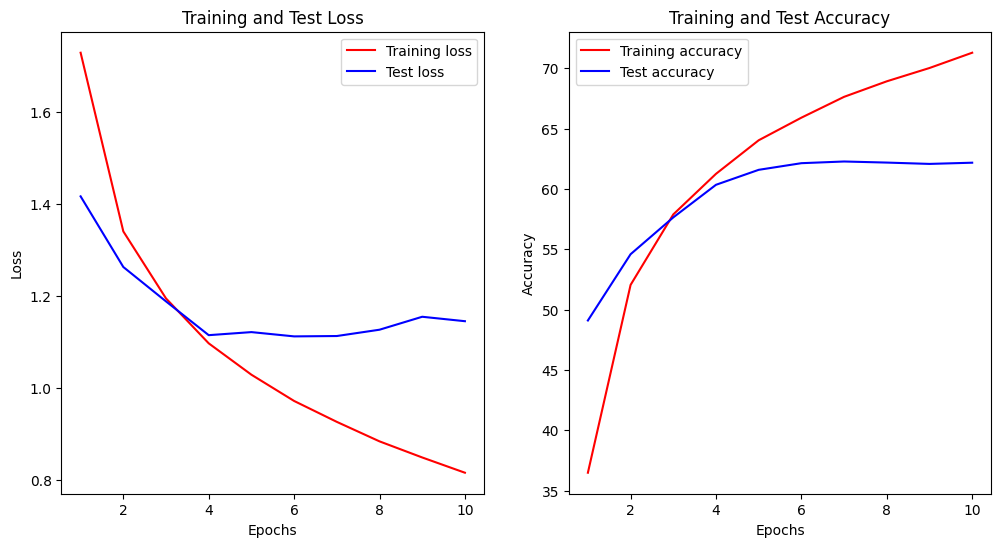

In [11]:
epoch_num = range(1, len(train_accs)+1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_num, train_losses, 'r', label='Training loss')
plt.plot(epoch_num, test_losses, 'b', label='Test loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_num, train_accs, 'r', label='Training accuracy')
plt.plot(epoch_num, test_accs, 'b', label='Test accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Brevitas PTQ

In [24]:
import brevitas.nn as qnn
from brevitas.quant import Int32Bias

class QuantWeightActBiasNet(nn.Module):
    def __init__(self):
        super(QuantWeightActBiasNet, self).__init__()
        self.quant_inp = qnn.QuantIdentity(bit_width=8, return_quant_tensor=True)
        self.conv1 = qnn.QuantConv2d(3, 6, 5, bias=True, weight_bit_width=8, bias_quant=Int32Bias, return_quant_tensor=True)
        self.relu1 = qnn.QuantReLU(bit_width=8, return_quant_tensor=True)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = qnn.QuantConv2d(6, 16, 5, bias=True, weight_bit_width=8, bias_quant=Int32Bias, return_quant_tensor=True)
        self.relu2 = qnn.QuantReLU(bit_width=8, return_quant_tensor=True)
        self.fc1 = qnn.QuantLinear(16 * 5 * 5, 120, bias=True, weight_bit_width=8, bias_quant=Int32Bias, return_quant_tensor=True)
        self.relu3 = qnn.QuantReLU(bit_width=8, return_quant_tensor=True)
        self.fc2 = qnn.QuantLinear(120, 84, bias=True, weight_bit_width=8, bias_quant=Int32Bias, return_quant_tensor=True)
        self.relu4 = qnn.QuantReLU(bit_width=8, return_quant_tensor=True)
        self.fc3 = qnn.QuantLinear(84, 10, bias=True, weight_bit_width=8, bias_quant=Int32Bias)

    def forward(self, x):
        x = self.quant_inp(x)
        x = self.relu1(self.conv1(x))
        x = self.pool(x)
        x = self.relu2(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

ptq_net = QuantWeightActBiasNet().to(device)

In [25]:
ptq_net.conv1.weight.data = net.conv1.weight.data.clone()
ptq_net.conv1.bias.data = net.conv1.bias.data.clone()
ptq_net.conv2.weight.data = net.conv2.weight.data.clone()
ptq_net.conv2.bias.data = net.conv2.bias.data.clone()
ptq_net.fc1.weight.data = net.fc1.weight.data.clone()
ptq_net.fc1.bias.data = net.fc1.bias.data.clone()
ptq_net.fc2.weight.data = net.fc2.weight.data.clone()
ptq_net.fc2.bias.data = net.fc2.bias.data.clone()
ptq_net.fc3.weight.data = net.fc3.weight.data.clone()
ptq_net.fc3.bias.data = net.fc3.bias.data.clone()

In [26]:
torchinfo.summary(ptq_net, (1, 3, 32, 32))

Layer (type:depth-idx)                                            Output Shape              Param #
QuantWeightActBiasNet                                             [1, 10]                   --
├─QuantIdentity: 1-1                                              [1, 3, 32, 32]            --
│    └─ActQuantProxyFromInjector: 2-1                             [1, 3, 32, 32]            --
│    └─ActQuantProxyFromInjector: 2-2                             [1, 3, 32, 32]            --
│    │    └─FusedActivationQuantProxy: 3-1                        [1, 3, 32, 32]            1
├─QuantReLU: 1-16                                                 --                        (recursive)
│    └─ActQuantProxyFromInjector: 2-27                            --                        (recursive)
│    │    └─FusedActivationQuantProxy: 3-17                       --                        (recursive)
├─QuantIdentity: 1-3                                              --                        (recursive)
│    └─Act

In [27]:
calculate_accuracy(testloader, ptq_net)

62.3

# QAT

In [28]:
import brevitas.nn as qnn
from brevitas.quant import Int32Bias

class QuantWeightActBiasNet(nn.Module):
    def __init__(self):
        super(QuantWeightActBiasNet, self).__init__()
        self.quant_inp = qnn.QuantIdentity(bit_width=8, return_quant_tensor=True)
        self.conv1 = qnn.QuantConv2d(3, 6, 5, bias=True, weight_bit_width=8, bias_quant=Int32Bias, return_quant_tensor=True)
        self.relu1 = qnn.QuantReLU(bit_width=8, return_quant_tensor=True)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = qnn.QuantConv2d(6, 16, 5, bias=True, weight_bit_width=8, bias_quant=Int32Bias, return_quant_tensor=True)
        self.relu2 = qnn.QuantReLU(bit_width=8, return_quant_tensor=True)
        self.fc1 = qnn.QuantLinear(16 * 5 * 5, 120, bias=True, weight_bit_width=8, bias_quant=Int32Bias, return_quant_tensor=True)
        self.relu3 = qnn.QuantReLU(bit_width=8, return_quant_tensor=True)
        self.fc2 = qnn.QuantLinear(120, 84, bias=True, weight_bit_width=8, bias_quant=Int32Bias, return_quant_tensor=True)
        self.relu4 = qnn.QuantReLU(bit_width=8, return_quant_tensor=True)
        self.fc3 = qnn.QuantLinear(84, 10, bias=True, weight_bit_width=8, bias_quant=Int32Bias)

    def forward(self, x):
        x = self.quant_inp(x)
        x = self.relu1(self.conv1(x))
        x = self.pool(x)
        x = self.relu2(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

qat_net = QuantWeightActBiasNet().to(device)

In [17]:
# Call the training function
qtrain_accs, qtrain_losses, qtest_accs, qtest_losses = train_model(qat_net, trainloader, testloader, num_epochs=10)

Start Training:
Epoch [1/10], Loss: 1.7683, Training Accuracy: 34.28%
Epoch [1/10], Test Loss: 1.4180, Test Accuracy: 48.23%
Epoch [2/10], Loss: 1.3705, Training Accuracy: 50.16%
Epoch [2/10], Test Loss: 1.2657, Test Accuracy: 54.38%
Epoch [3/10], Loss: 1.2496, Training Accuracy: 54.90%
Epoch [3/10], Test Loss: 1.2411, Test Accuracy: 55.36%
Epoch [4/10], Loss: 1.1778, Training Accuracy: 57.98%
Epoch [4/10], Test Loss: 1.2246, Test Accuracy: 55.96%
Epoch [5/10], Loss: 1.1248, Training Accuracy: 59.97%
Epoch [5/10], Test Loss: 1.1845, Test Accuracy: 58.39%
Epoch [6/10], Loss: 1.0780, Training Accuracy: 61.87%
Epoch [6/10], Test Loss: 1.1959, Test Accuracy: 58.14%
Epoch [7/10], Loss: 1.0393, Training Accuracy: 63.33%
Epoch [7/10], Test Loss: 1.1833, Test Accuracy: 58.60%
Epoch [8/10], Loss: 1.0038, Training Accuracy: 64.45%
Epoch [8/10], Test Loss: 1.1404, Test Accuracy: 60.46%
Epoch [9/10], Loss: 0.9706, Training Accuracy: 65.63%
Epoch [9/10], Test Loss: 1.1209, Test Accuracy: 60.38%
Epo

# Compare the Original / QAT models results

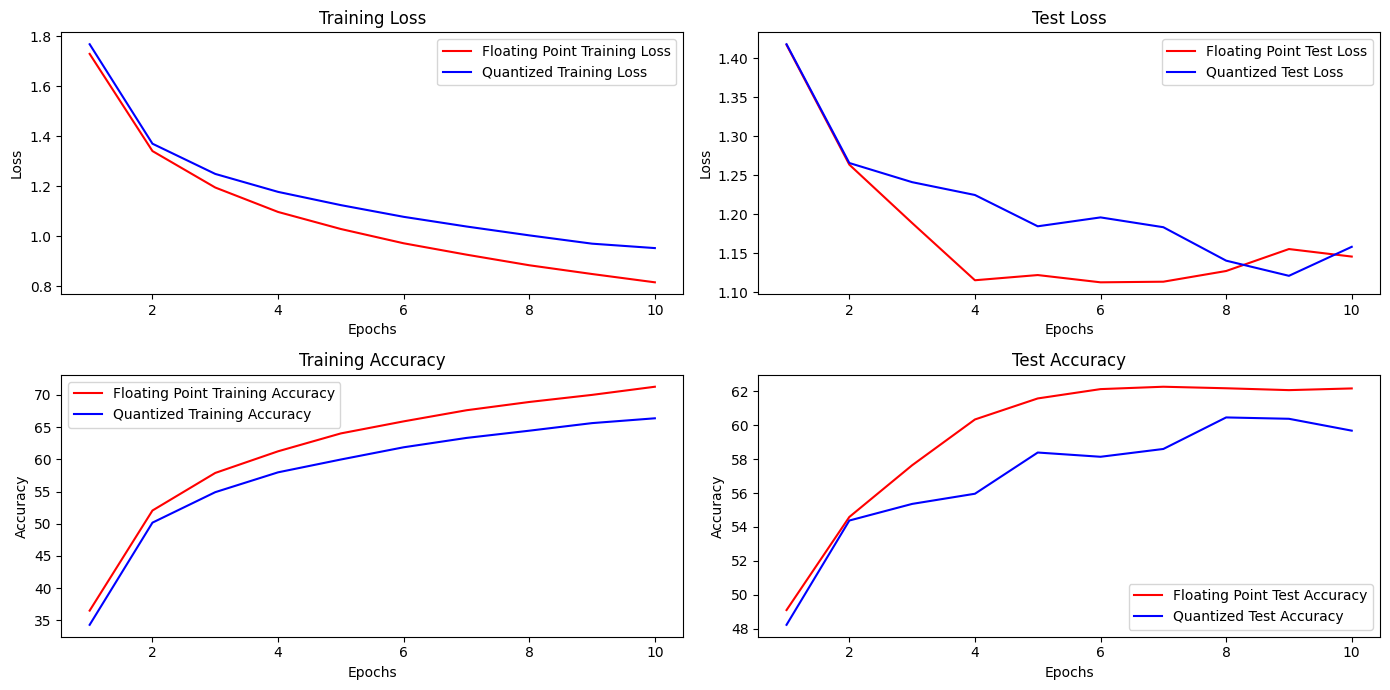

In [18]:
epochs = range(1, len(train_accs) + 1)

plt.figure(figsize=(14, 7))

# Plotting Training Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Floating Point Training Loss')
plt.plot(epochs, qtrain_losses, 'b', label='Quantized Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Test Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, test_losses, 'r', label='Floating Point Test Loss')
plt.plot(epochs, qtest_losses, 'b', label='Quantized Test Loss')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, train_accs, 'r', label='Floating Point Training Accuracy')
plt.plot(epochs, qtrain_accs, 'b', label='Quantized Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Test Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, test_accs, 'r', label='Floating Point Test Accuracy')
plt.plot(epochs, qtest_accs, 'b', label='Quantized Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# PTQ + QAT

## Try Implement by yourself!